In [4]:
from io import open
import glob
import os

In [2]:
import urllib.request
urllib.request.urlretrieve("https://download.pytorch.org/tutorial/data.zip", "data.zip")

('data.zip', <http.client.HTTPMessage at 0x25cbc74f850>)

In [3]:
import zipfile

with zipfile.ZipFile("data.zip", 'r') as zip_ref:
    zip_ref.extractall(".")

In [23]:
def findFiles(path):
    return glob.glob(path)

print(findFiles('data/names/*.txt'))

import unicodedata
import string

all_letters = string.ascii_letters + ".,;"
n_letters = len(all_letters)

def unicodeToAscii(s):
    return ''.join(
        c for c in unicodedata.normalize('NFD', s)
        if unicodedata.category(c) != 'Mn' and c in all_letters
    )

category_lines = {}
all_categories = []

def readLines(filename):
    lines = open(filename, encoding='utf-8').read().strip().split('\n')
    return [unicodeToAscii(line) for line in lines]

for filename in findFiles('data/names/*.txt'):
    category = os.path.splitext(os.path.basename(filename))[0]
    all_categories.append(category)
    lines = readLines(filename)
    category_lines[category] = lines

n_categories = len(all_categories)

['data/names\\Arabic.txt', 'data/names\\Chinese.txt', 'data/names\\Czech.txt', 'data/names\\Dutch.txt', 'data/names\\English.txt', 'data/names\\French.txt', 'data/names\\German.txt', 'data/names\\Greek.txt', 'data/names\\Irish.txt', 'data/names\\Italian.txt', 'data/names\\Japanese.txt', 'data/names\\Korean.txt', 'data/names\\Polish.txt', 'data/names\\Portuguese.txt', 'data/names\\Russian.txt', 'data/names\\Scottish.txt', 'data/names\\Spanish.txt', 'data/names\\Vietnamese.txt']


In [24]:
print(category_lines['Korean'][:5])

['Ahn', 'Baik', 'Bang', 'Byon', 'Cha']


In [25]:
import torch

def letterToIndex(letter):
    return all_letters.find(letter)

def letterToTensor(letter):
    tensor = torch.zeros(1, n_letters)
    tensor[0][letterToIndex(letter)] = 1
    return tensor

def lineToTensor(line):
    tensor = torch.zeros(len(line), 1, n_letters)
    for li, letter in enumerate(line):
        tensor[li][0][letterToIndex(letter)] = 1
    return tensor

print(letterToTensor('J'))

print(lineToTensor('Jones').size())

tensor([[0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
         0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1.,
         0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
         0.]])
torch.Size([5, 1, 55])


## 신경망 생성

In [26]:
import torch.nn as nn

class RNN(nn.Module):
    def __init__(self, input_size, hidden_size, output_size):
        super(RNN, self).__init__()

        self.hidden_size = hidden_size

        self.i2h = nn.Linear(input_size + hidden_size, hidden_size)
        self.i2o = nn.Linear(input_size + hidden_size, output_size)
        self.softmax = nn.LogSoftmax(dim=1)

    def forward(self, input, hidden):
        combined = torch.cat((input, hidden), 1)
        hidden = self.i2h(combined)
        output = self.i2o(combined)
        output = self.softmax(output)
        return output, hidden

    def initHidden(self):
        return torch.zeros(1, self.hidden_size)
    
n_hidden = 128
rnn = RNN(n_letters, n_hidden, n_categories)

In [27]:
input = letterToTensor('A')
hidden = torch.zeros(1, n_hidden)

output, next_hidden = rnn(input, hidden)
print(output)

tensor([[-2.9507, -2.9440, -2.9134, -2.9128, -2.9122, -2.7674, -2.9707, -2.9189,
         -2.8371, -2.8708, -2.7918, -2.9341, -2.9568, -2.8195, -2.9403, -2.8929,
         -2.8433, -2.8801]], grad_fn=<LogSoftmaxBackward0>)


In [28]:
input = lineToTensor('Albert')
hidden = torch.zeros(1, n_hidden)

output, next_hidden = rnn(input[0], hidden)
print(output)

tensor([[-2.9507, -2.9440, -2.9134, -2.9128, -2.9122, -2.7674, -2.9707, -2.9189,
         -2.8371, -2.8708, -2.7918, -2.9341, -2.9568, -2.8195, -2.9403, -2.8929,
         -2.8433, -2.8801]], grad_fn=<LogSoftmaxBackward0>)


## Model Training

In [29]:
def categoryFromOutput(output):
    top_n, top_i = output.topk(1)
    category_i = top_i[0].item()
    return all_categories[category_i], category_i
print((categoryFromOutput(output)))

('French', 5)


In [32]:
import random

def randomChoice(l):
    return l[random.randint(0, len(l) - 1)]

def randomTrainingExample():
    category = randomChoice(all_categories)
    line = randomChoice(category_lines[category])
    category_tensor = torch.tensor([all_categories.index(category)], dtype = torch.long)
    line_tensor = lineToTensor(line)
    return category, line, category_tensor, line_tensor

for i in range(10):
    category, line, category_tensor, line_tensor = randomTrainingExample()
    print('category: {} \tline: {}'.format(category, line))

category: Greek 	line: Sardelis
category: Vietnamese 	line: Lam
category: German 	line: Kohl
category: Czech 	line: Samz
category: Arabic 	line: Issa
category: Arabic 	line: Atiyeh
category: Spanish 	line: Oquendo
category: English 	line: Fairbrace
category: Polish 	line: Chmiel
category: French 	line: Abel


## Loss Function

In [33]:
criterion = nn.NLLLoss()

In [35]:
# model Training

learning_rate = 5e-3

def train(category_tensor, line_tensor):
    hidden = rnn.initHidden()
    rnn.zero_grad()

    for i in range(line_tensor.size()[0]):
        output, hidden = rnn(line_tensor[i], hidden)

    loss = criterion(output, category_tensor)
    loss.backward()

    for p in rnn.parameters():
        p.data.add_(p.grad.data, alpha=-learning_rate)

    return output, loss.item()

In [37]:
import time
import math

n_iters = 100000
print_every = 5000
plot_every = 1000

current_loss = 0
all_losses =[]
def timeSince(since):
    now = time.time()
    s = now - since
    m = math.floor(s/60)
    s -= m*60
    return '%dm %ds' %(m, s)

start = time.time()

for iter in range(1, n_iters + 1):
    category, line, category_tensor, line_tensor = randomTrainingExample()
    output, loss = train(category_tensor, line_tensor)
    current_loss += loss

    if iter % print_every == 0:
        guess, guess_i = categoryFromOutput(output)
        correct = 'O' if guess == category else 'X (%s)' % category
        print('%d %d%% (%s) %.4f %s / %s %s' % (iter, iter/n_iters*100, timeSince(start), loss, line, guess, correct))

    if iter % plot_every == 0:
        all_losses.append(current_loss / plot_every)
        current_loss = 0

5000 5% (0m 2s) 2.8193 Winfield / Irish X (English)
10000 10% (0m 4s) 0.6614 Tanizaki / Japanese O
15000 15% (0m 7s) 1.7582 Nagumo / Arabic X (Japanese)
20000 20% (0m 9s) 3.5239 Day / Chinese X (English)
25000 25% (0m 12s) 1.1347 Mckenzie / Scottish O
30000 30% (0m 14s) 0.4564 Truong / Vietnamese O
35000 35% (0m 16s) 0.9659 Etxebarria / Spanish O
40000 40% (0m 19s) 1.3121 Naifeh / Arabic O
45000 45% (0m 21s) 3.8372 Ivor / German X (Irish)
50000 50% (0m 23s) 2.5218 Bohn / Irish X (German)
55000 55% (0m 26s) 0.2452 Quyen / Vietnamese O
60000 60% (0m 28s) 3.0408 Gaspar / Arabic X (Portuguese)
65000 65% (0m 30s) 0.0302 Anderson / Scottish O
70000 70% (0m 33s) 1.1898 Spano / Italian O
75000 75% (0m 35s) 0.5372 Acciai / Italian O
80000 80% (0m 37s) 2.1912 Sassa / Czech X (Japanese)
85000 85% (0m 40s) 4.1644 Maly / Irish X (Czech)
90000 90% (0m 42s) 1.0685 Mohren / Dutch O
95000 95% (0m 44s) 0.6701 Ruvelas / Greek O
100000 100% (0m 47s) 2.8780 Unterbrink / French X (German)


C:\Users\jjong\AppData\Local\Temp\ipykernel_19588\329533789.py:3: MatplotlibDeprecationWarning: The seaborn styles shipped by Matplotlib are deprecated since 3.6, as they no longer correspond to the styles shipped by seaborn. However, they will remain available as 'seaborn-v0_8-<style>'. Alternatively, directly use the seaborn API instead.
  plt.style.use('seaborn-white')


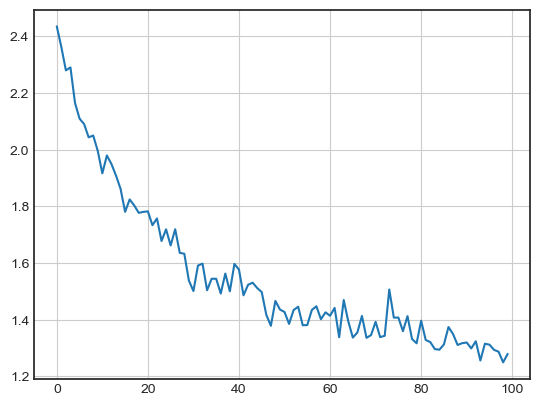

In [39]:
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
plt.style.use('seaborn-white')

plt.figure()
plt.plot(all_losses)
plt.grid()
plt.show()

## Model Test

C:\Users\jjong\AppData\Local\Temp\ipykernel_19588\3396514540.py:26: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels([''] + all_categories, rotation=90)
C:\Users\jjong\AppData\Local\Temp\ipykernel_19588\3396514540.py:27: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_yticklabels([''] + all_categories)


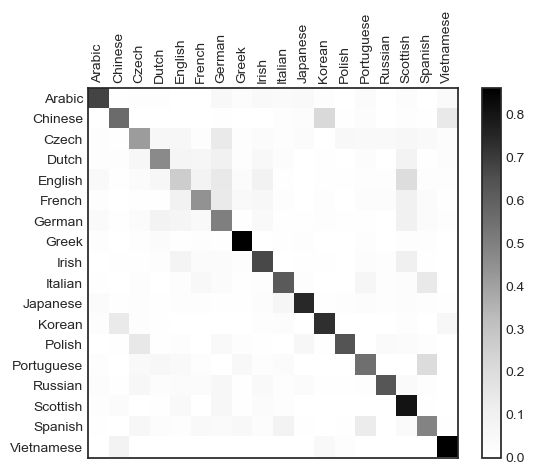

In [42]:
confusion = torch.zeros(n_categories, n_categories)
n_confusion = 10000

def evaluate(line_tensor):
    hidden = rnn.initHidden()

    for i in range(line_tensor.size()[0]):
        output, hidden = rnn(line_tensor[i], hidden)
    
    return output

for i in range(n_confusion):
    category, line, category_tensor, line_tensor = randomTrainingExample()
    output = evaluate(line_tensor)
    guess, guess_i = categoryFromOutput(output)
    category_i = all_categories.index(category)
    confusion[category_i][guess_i] += 1

for i in range(n_categories):
    confusion[i] = confusion[i] / confusion[i].sum()

fig = plt.figure()
ax = fig.add_subplot(111)
cax = ax.matshow(confusion.numpy())
fig.colorbar(cax)
ax.set_xticklabels([''] + all_categories, rotation=90)
ax.set_yticklabels([''] + all_categories)
ax.xaxis.set_major_locator(ticker.MultipleLocator(1))
ax.yaxis.set_major_locator(ticker.MultipleLocator(1))
plt.show()

In [62]:
def predict(input_line, n_predictions=3):
    print('\n> %s' % input_line)
    with torch.no_grad():
        output = evaluate(lineToTensor(input_line))

        topv, topi = output.topk(n_predictions, 1, True)
        predictions = []

        for i in range(n_predictions):
            value = topv[0][i].item()
            category_index = topi[0][i].item()
            print('(%.2f) %s' % (value, all_categories[category_index]))
            predictions.append([value, all_categories[category_index]])

predict('Jackson')
predict('Bill')
predict('Doveski')
predict('Lee')
predict('Park')


> Jackson
(-0.49) Scottish
(-1.28) English
(-3.05) Russian

> Bill
(-1.28) English
(-1.73) Scottish
(-2.05) Irish

> Doveski
(-1.04) Czech
(-1.27) Russian
(-1.68) Polish

> Lee
(-0.95) Vietnamese
(-1.13) Chinese
(-2.63) French

> Park
(-1.76) Czech
(-1.83) Dutch
(-2.03) Polish
